### Part IB Computing Exercise
# Modeling a tension experiment in atomistic detail

_Michaelmas Term, 2017, Engineering Laboratory, University of Cambridge, Prof. Gábor Csányi (gc121)_

![bar](./copper-bar-zoom.png)

In this exercise you will develop a simple, _atomic scale_ model of how metals respond under tensile stress. Simulating the response in such detail will allow you an insight into how dislocations are actually generated and interact to provide the plasticity of the material and relieve the large local stresses. 

In the course of the exercise, you will:

1. Create and manipulate atomic scale structural models of crystalline matter
1. Compute simple elastic properties of single crystal copper (Cu)
1. Set up and run a strain controlled tensile test simulation of a notched bar
1. Examine newly created dislocations on the atomic scale

This activity introduces you to _scientific computing_, the use of programming and numerical techniques to model, investigate and learn about a technical subject, in this case materials engineering. 


## Software Environment

You will be using a python package called [Atomic Simulation Environment](https://gitlab.com/ase/ase) (ASE), which you will need to download. It has excellent tutorials at its [documentation page](https://wiki.fysik.dtu.dk/ase/), but the first few exercises below will teach you many of the elements of ASE you will need for this project. Also try to install the ```matscipy``` package (which needs a working C++ compiler), if that is successful your simulations will be much faster. 

It is recommended that you obtain a Python environment on your own computer such as [Anaconda](http://anaconda.org). However, much of this exercise can be completed using a cloud-based notebook server, such as Azure, in which case you can try installing the needed packages by using ```!pip install ase```, etc. directly in your notebook. Not all cloud-based servers will let you install packages, and the second part of the exercise is much easier done on your own computer. 

The ```!pip install ase``` and ```!pip install matscipy``` commands also work in an ```anaconda``` Python console or a Jupyter notebook that is running on your own computer, or without the "!" in a normal command terminal. 

_Note: There are several files associated with this notebook, both images and python code (e.g. Morse.py), make sure they are in the same folder as this notebook._

##### Notes for various operating systems

* On Mac OS, it is recommended that you do not work with the Python supplied by Apple, but get your own, e.g. Anaconda, or use Homebrew. 

* On Windows, you will need MS Visual C++ in order to use the matscipy package (MSVC++ version 14 for use with Python versions > 3.5)

* If you are working on the Linux workstations in the Department,  see [this page](http://www-h.eng.cam.ac.uk/help/languages/python/pythonatcued.html) on how to install new Python packages for yourself. Note that the Ovito visualisation software (see Milestone 2 below) is not yet installed on the DPO workstations by default.  

## Software Engineering

You will be working on your own for this lab. Use the skills and techniques that you learned in the [Part IA Lent Computing Exercise](http://cued-partia-flood-warning.readthedocs.io/en/latest/index.html), and review them before you start if necessary. In particular:

- The first half of the exercise is to be done in this notebook right here.  
- Please use Python 3 rather than earlier versions.
- Keep to the good code documentation practices you learned in Part IA.

It will be assumed from now on that you know how to use these tools. 


## Materials and structural engineering

Since the topic of this exercise is the response of matter to loading, it will be beneficial if you review the related concepts in the IA Materials and Structures courses, particularly on _stress_, _strain_, _bulk modulus_, _shear modulus_, _Poisson ratio_, and _dislocations_.

## Learning objectives and assessment

### Learning objectives

#### Programming skills

- Effective use of python programming, as developed in Part IA
- Appropriate use of NumPy arrays, functions, Python classes, class members and member functions. 
- Clear organisation of simulation code, parameter settings and corresponding results. 

#### Scientific Computing

- Making connections between abstract concepts of elastic deformation and numerical representations in a compute model
- Ability to calculate elastic properties of materials numerically using an atomistic model
- Identifying atomic scale processes underlying plastic deformation via dislocation nucleation and glide 


### Assessment guidelines

The following criteria will be used in assessing your implementation. Markers will want to view your Notebook for the first milestone, and your simulation parameters, results and analysis for the second milestone.

Your Notebook should display an understanding of the basic aspects of materials engineering involved. Your results should have the correct units, plots have axes correctly labeled. 

#### Code

- Your notebook and programs should execute without error.
- Programs should be correct and achieve the specified deliverables.
- Numerical results should be printed with notes on what they represent, and appropriate units. 
- Clarity and structure of the code implementations.
- Re-use of functions and python objects where appropriate.
- Documentation of your functions, and comments in the Notebook and standalone code to enhance readability


In [1]:
!pip install ase

## Preliminaries, Examples, Milestones and Deliverables

The rest of this notebook contains background information that you need to understand the exercise, bits of example code that teaches you how to use the ASE package, milestones that help you track your progress, and __specific deliverables (marked in bold)__ that you need to present to the markers. 

### Milestone 1

Basic use of ASE, computation of the elastic properties of a single crystal of copper. Do the tasks right here in this notebook. Bring the completed notebook to the a marking session, at latest by the middle of Term.

### Task 1.1

You are going to use a simple model to describe the interaction of atoms, called the "Morse potential", 
which assumes that atoms interact with each other pairwise, and the total potential energy of a collection of atoms is

$$
E_{total} = \sum_{i < j} V_{M}(r_{ij})
$$

where the double sum runs over the indices of every pair of atoms (counting every pair only once), $r_{ij}$ is the distance between atoms $i$ and $j$, and the _interaction potential_ is given by

$$
V_{M}(r) = D \left[e^{-2\alpha (r-r_0))} - 2e^{-\alpha (r-r_0))} \right]
$$

There are three adjustable parameters in this model. You can think of $D$ as fixing the energy scale of the model, $r_0$ as fixing the distance between neighbouring atoms, and $\alpha$ as fixing the length scale over which the interaction between atoms decays (in inverse length units). 

In the small scale world of atoms, it is convenient to measure energies in _electron Volts_ (eV), with 1 eV $\approx 1.6 \times 10^{-19}~$J, and distances in _Ångstroms_ (Å), with 1 Å = $10^{-10}~$m, and these are the intrinsic units of ASE. All other derived units follow from this, e.g. forces are in eV/Å, stresses are in eV/Å$^3$. ASE provides the constant ```GPa``` that can be used to convert pressures and stresses from eV/Å$^3$ into GPa units. 

Here is how to create an object that represents just two copper atoms with a distance 2.5 Å between them:

In [2]:
from __future__ import print_function
import numpy as np
from ase import Atoms
from ase.units import eV, Ang, GPa
d = 2.5*Ang
a = Atoms('2Cu', positions=[(0., 0., 0.), (0., 0., d)])

The ```positions``` array contains the x, y, z coordinates of each atom, in that order. 

Now attach a ```calculator``` (ASE-speak for a model that can compute energies, forces and stresses on atoms) to this object, and compute its potential energy. (Any time you create a new atoms object, you need to set its calculator, but you can reuse the same calculator object)

In [3]:
import Morse
calc = Morse.MorsePotential()

a.set_calculator(calc) 
a.get_potential_energy()

-0.14929402163819286

Changing the position of the second atom allows the evaluation of the potential energy as a function of distance

In [4]:
p = a.get_positions()
p

array([[ 0. ,  0. ,  0. ],
       [ 0. ,  0. ,  2.5]])

In [5]:
p[1,2] = 2.8
p

array([[ 0. ,  0. ,  0. ],
       [ 0. ,  0. ,  2.8]])

In [6]:
a.set_positions(p)
a.get_potential_energy()

-0.14510421337089219

You can also manipulate the positions of the atoms directly by access the array inside the ```Atoms``` object:

In [7]:
a.positions[1,2] = 2.9
a.get_positions()
f = a.get_forces()
f

array([[ 0.        ,  0.        ,  0.16719099],
       [ 0.        ,  0.        , -0.16719099]])

The forces exerted by the atoms on one another can be obtained analogously. Remember that the force is the negative of the 3-dimensional gradient vector of the potential energy. (But there is no directly accessible array in the ```Atoms``` object that holds the forces, you have to use the function call)

In [8]:
f = a.get_forces()
print(np.linalg.norm(f[0]))

0.167190994226


### Deliverable 1.1

__Write a function that computes the Morse potential energy for two atoms for a given distance between them, and use it to create a plot of the energy against distance. Now do the same for the magnitude of the force exerted by one atom on the other.__

__What is the distance between the two atoms corresponding to the lowest potential energy ? __

Hint: You can create an array of distances (think about what is a sensible range, you don't want atoms to be too close!), and for each one create the Atoms object and compute the potential energy and forces. 

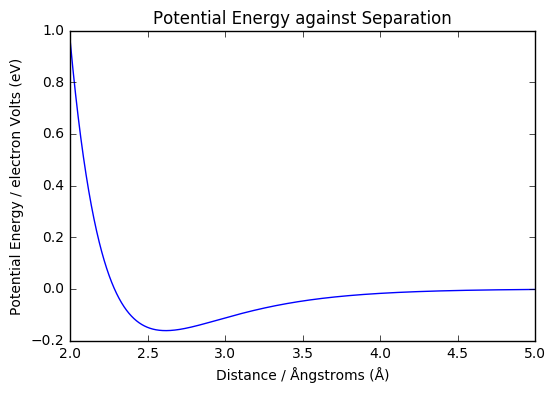

In [9]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

distances = np.arange(2.0*Ang, 5.0*Ang, 0.001*Ang)
def PE_calc(distance):
    """Takes atomic distance as input and returns potential energy between atoms"""
    a = Atoms('2Cu', positions=[(0., 0., 0.), (0., 0., distance)])
    calc = Morse.MorsePotential()
    a.set_calculator(calc)
    return a.get_potential_energy()



PE = []
for distance in distances:
    PE_temp = PE_calc(distance)
    PE.append(PE_temp)

    
plt.plot(distances, PE)
plt.xlabel('Distance / Ångstroms (Å)')
plt.ylabel('Potential Energy / electron Volts (eV)')
plt.title('Potential Energy against Separation')
plt.show()

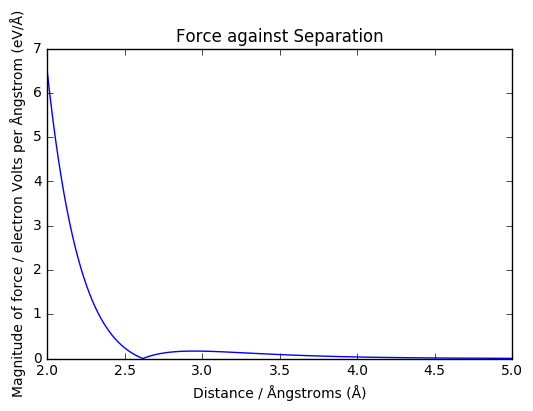

In [10]:
def F_calc(distance):
    """Takes atomic distance as input and returns force magnitude"""
    a = Atoms('2Cu', positions=[(0., 0., 0.), (0., 0., distance)])
    calc = Morse.MorsePotential()
    a.set_calculator(calc)
    return np.linalg.norm(a.get_forces()[0])

F = []
for distance in distances:
    F_temp = F_calc(distance)
    F.append(F_temp)
    
plt.plot(distances, F)
plt.xlabel('Distance / Ångstroms (Å)')
plt.ylabel('Magnitude of force / electron Volts per Ångstrom (eV/Å)')
plt.title('Force against Separation')
plt.show()

r = ~2.616 Å corresponds to the lowest potential energy.

### Task and Deliverable 1.2 

__Write a _unit test_ that verifies that the forces returned by the ```get_forces()``` function is really the negative gradient of the energy (as returned by the ```get_potential_energy()``` function) with respect to the atomic positions. Do this by comparing the returned forces to those obtained by numerical finite differences of energies between two sets of atomic positions, displaced by small amount.__

Hint:

Use the idea of the definition of the gradient and its relation to the Taylor expansion:

$$
\nabla f(x) \approx \frac{f(x+\epsilon)-f(x)}{\epsilon}
$$

With just two atoms in the "system", you can treat the energy and force as just functions of a scalar variable, the distance between the two atoms. More generally, both the energy and the forces are functions of many atomic coordinates, which we can collect into a vector $\bf{R}$, so the truncated Taylor expansion takes the form:

$$
\nabla f({\bf R})\cdot {\bf d} \approx \frac{f ({\bf R}+\epsilon {\bf d} )-f({\bf R})}{\epsilon}
$$

where ${\bf d}$ is the vector representing a small displacement. 

__Experiment with different values of $\epsilon$ and look at how accurate the approximation is as a function of $\epsilon$. What goes wrong if you make $\epsilon$ too small?__

In [11]:
import pytest

e = [0.1*Ang, 0.01*Ang, 0.001*Ang]#0.0001*Ang
def test_get_forces():
    values = []
    for step in e:
        distances = np.arange(3.5*Ang, 4.0*Ang, step)
        errors = []
        for distance in distances:
            PE_temp = PE_calc(distance)
            PE_temp1 = PE_calc(distance + step)
            grad_temp = (PE_temp1 - PE_temp) / step
            F_temp = F_calc(distance)
            error = (((abs(grad_temp - F_temp)) / F_temp) * 100)
            errors.append(error)
            assert error < 1, "Error greater than 1%!"

        values.append("Max %error for step of " + str(step) + " is " + str(max(errors)))
        values.append("Min %error for step of " + str(step) + " is " + str(min(errors)))
        
    return values
    
        
test_get_forces()

['Max %error for step of 0.1 is 9.14697122104',
 'Min %error for step of 0.1 is 8.17904193495',
 'Max %error for step of 0.01 is 0.977749836882',
 'Min %error for step of 0.01 is 0.847688892793',
 'Max %error for step of 0.001 is 0.0984351191759',
 'Min %error for step of 0.001 is 0.0850588822539']

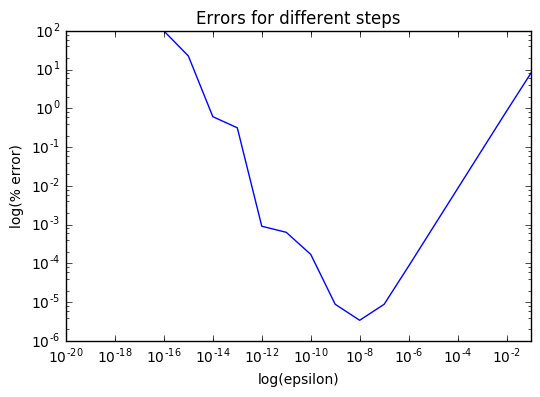

In [59]:
epsilon = [10**i for i in range(-20, 0)]
distance = 3.5*Ang
errors=[]
for step in epsilon:
    
    PE_temp = PE_calc(distance)
    PE_temp1 = PE_calc(distance + step)
    grad_temp = (PE_temp1 - PE_temp) / step
    F_temp = F_calc(distance)
    error = (((abs(grad_temp - F_temp)) / F_temp) * 100)
    errors.append(error)
    
plt.plot(epsilon, errors)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('log(epsilon)')
plt.ylabel('log(% error)')
plt.title('Errors for different steps')
plt.show()

### Task 1.3

_Create a cubic unit cell of the Cu crystal, and extract some of its properties._

In order to investigate the properties of bulk copper, we need to model a large number of atoms. But evaluating the total potential energy of a large number of atoms takes a long time, and so we need a shortcut. In fact many simple properties of a crystalline solid can be evaluated by just considering its _unit cell_, i.e. the smallest repeating unit from which the crystal is made. This is typically true for static properties that do not depend on atoms experiencing a variety of neighbour environments, i.e. in the absence of _defects_. Such properties include the _lattice constant_ (i.e. the density), the _equation of state_, the _elastic constants_ (including the _bulk modulus_), the _Poisson ratio_, etc. 

The trick is to _assume_ that the atoms are arranged in perfect crystalline order, and only explicitly consider those atoms that are in a single unit cell. In order to correctly evaluate the energy, the _effect_ of atoms in neighbouring unit cells needs to be included, but this can be done by using [_periodic boundary conditions_](https://en.wikipedia.org/wiki/Periodic_boundary_conditions). The page behind the link is rather detailed, but think about the Fourier Series from IA maths, which was applicable to periodic functions, but you only ever had to consider the function values over a single period. This is similar. 

In the image below, the blue shaded area is the unit cell, its sides are the lattice vectors that generate the periodic images. 

![Periodic cells](unitcell2.png)

More complicated properties, such as the _yield stress_, or those of more complicated materials such as _polycrystalline solids_ cannot be extracted from such small unit cells.

The crystal structure of Cu is face centered cubic, and ASE provides convenient constructors which assume periodic boundary conditions, unless instructed otherwise:

In [12]:
from ase.build import bulk
cu = bulk("Cu", "fcc", a=3.6, cubic=True)

![cu](./cu.png)

Although the smallest possible unit cell of an fcc crystal contains just one atom, it is often more convenient to work with the "cubic unit cell" which contains 4 atoms, but whose lattice vectors (which represent the displacements that correspond to the periodically repeating units) are just the sides of a cube, i.e. orthogonal and correspond to the x, y, and z axes. The size of the lattice vectors determine the volume of the unit cell and the corresponding density of material modelled. 

The fcc crystal you have seen before probably show an atom in each face of the cubic unit cell - but many of those are repeated periodic images of the ones shown above!

In ASE, the lattice vectors are stored, side-by-side, collected together in a 3x3 matrix called _cell_. So, the first column is the first lattice vector ($L_1$), the second column is the second lattice vector($L_2$), and the third column is the third lattice vector ($L_3$).

$$
\left[ \begin{matrix} L_{1x} &L_{2x} &L_{3x}\\ L_{1y} &L_{2y}&L_{3y}\\ L_{1z} &L_{2z}&L_{3z} \end{matrix}\right]
$$

In [13]:
cu.get_cell()

array([[ 3.6,  0. ,  0. ],
       [ 0. ,  3.6,  0. ],
       [ 0. ,  0. ,  3.6]])

There are indeed 4 atoms in this unit cell, with positions corresponding to the origin, and the centers of the sides of the unit cube on the YZ, ZX and XY planes:

In [14]:
cu.get_positions()

array([[ 0. ,  0. ,  0. ],
       [ 0. ,  1.8,  1.8],
       [ 1.8,  0. ,  1.8],
       [ 1.8,  1.8,  0. ]])

Verify that the periodic boundary conditions are implemented correctly by evaluating the potential energy of the unit cell, and comparing the potential energy per atom to that of a larger cell, which is obtained by replicating the original twice in each of the three directions. Since both smaller and larger cells represent an infinite, periodic array of copper atoms, the potential energy per atom should be the same. 

In [15]:
cu.set_calculator(calc)
print("Number of atoms: ", cu.get_number_of_atoms())
print("Potential energy per atom: ", cu.get_potential_energy()/cu.get_number_of_atoms())

Number of atoms:  4
Potential energy per atom:  -1.16990719273


In [16]:
cu222 = cu.copy()        # creating a copy of an Atoms object
cu222.set_calculator(calc) # copying DOES NOT bring the attached calculator, so we need to set it again
cu222 *= (2,2,2)         # replicating the unit cell is accomplished by the multiplying operator
print("Number of atoms: ", cu222.get_number_of_atoms())
print("Potential energy per atom: ", cu222.get_potential_energy()/cu222.get_number_of_atoms())

Number of atoms:  32
Potential energy per atom:  -1.16990719273


![cu222](./cu222.png)

Strain can be applied to the system by modifying (distorting) the unit cell appropriately. E.g. to apply 1% hydrostatic compression:

In [17]:
cell = cu.get_cell()
cell *= 0.99
cu.set_cell(cell, scale_atoms=True) # To apply strain, the atomic positions need to be scaled together with the unit cell 
cu.get_cell()

array([[ 3.564,  0.   ,  0.   ],
       [ 0.   ,  3.564,  0.   ],
       [ 0.   ,  0.   ,  3.564]])

In [18]:
cu.get_potential_energy()/cu.get_number_of_atoms()

-1.1657718984261178

The stress on the system is given as a matrix, here we get it as a 3x3 matrix (ASE's default is to provide it in [Voigt notation](https://en.wikipedia.org/wiki/Voigt_notation))

In [19]:
a = cu.get_stress(voigt=False)
a

array([[ -2.33782806e-02,  -0.00000000e+00,   1.53277060e-18],
       [ -0.00000000e+00,  -2.33782806e-02,   8.04704564e-19],
       [  1.53277060e-18,   8.04704564e-19,  -2.33782806e-02]])

The stress, analogously to the force, is the derivative of the energy with respect to the unit cell vectors (or more precisely, with respect to the deformation strain applied to the unit cell vectors). Note how the off-diagonal elements of the stress matrix above are essentially zero and the diagonal elements are the same, i.e. the stress is the same in the X, Y, and Z directions, corresponding to the 1% hydrostatic compression that we applied above. 

### Deliverable 1.3

- __Write a program that calculates and plots the potential energy and pressure (P) of the copper crystal as a function of volume by applying varying amounts of hydrostatic strain.__
- __Calculate the [bulk modulus](https://en.wikipedia.org/wiki/Bulk_modulus) at the equilibrium volume. Compare it to the experimental value.__

Hints:

- Make sure you use a sensible range of strains, think about what would be reasonable in a real experiment
- For the plot, use both compressive and tensile strains. Make sure you plot against the volume, not against the strain itself.
- Remember that $K = -V dP/dV$ where $V$ is the volume, and that the pressure is related to the trace of the stress matrix (S), $P = - \frac{1}{3} \text{Tr}(S)$.
- Do not forget that energy and volume are extensive, so it is best to work with the per-atom quantities.
- Do not be surprised that you only get within the experimental value within 10% or so. 

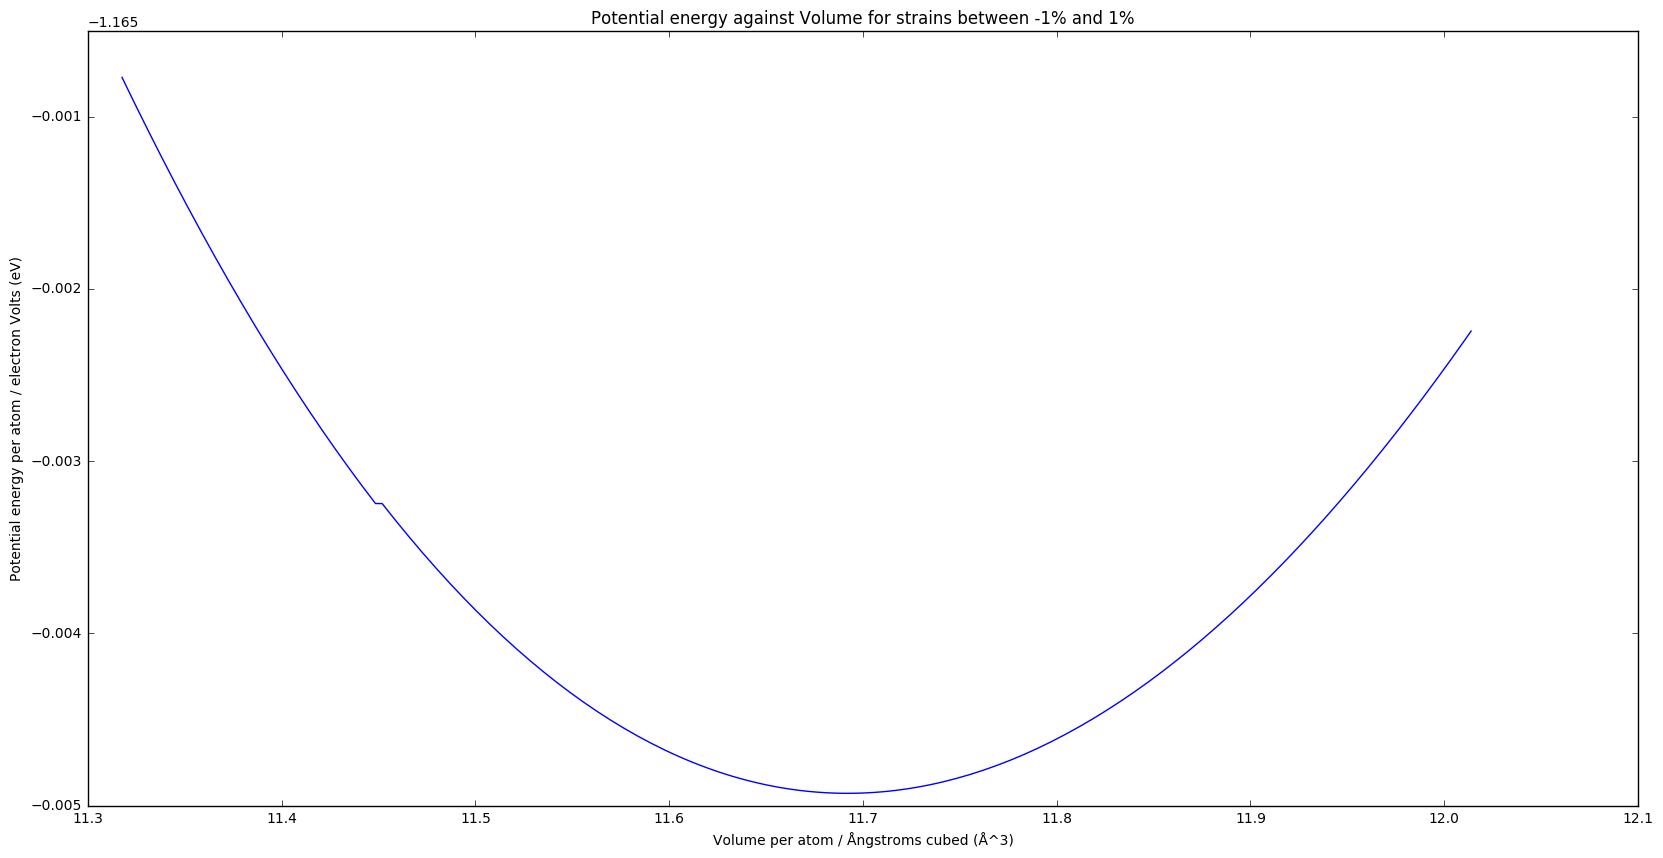

In [46]:
from ase.build import bulk

def strainer(strain):
    cu = bulk("Cu", "fcc", a=3.6, cubic=True)
    cu.set_calculator(calc)
    cell = cu.get_cell()
    cell *= 1 + strain # Tensile strain is positive
    cu.set_cell(cell, scale_atoms=True)
    PE_per_atom = cu.get_potential_energy()/cu.get_number_of_atoms()
    pressure = (-1/3) * np.matrix.trace(cu.get_stress(voigt=False))
    volume_per_atom = (cu.get_volume()) / cu.get_number_of_atoms()
    return PE_per_atom, pressure, volume_per_atom

strains = np.arange(-0.01, 0.01, 0.0001)
PE_list = []
pressure_list = []
volume_list = []
for strain in strains:
    PE_list.append(strainer(strain)[0])
    pressure_list.append(strainer(strain)[1])
    volume_list.append(strainer(strain)[2])

plt.figure(figsize = (20,10))
plt.plot(volume_list, PE_list)
plt.xlabel('Volume per atom / Ångstroms cubed (Å^3)')
plt.ylabel('Potential energy per atom / electron Volts (eV)')
plt.title('Potential energy against Volume for strains between -1% and 1%')
plt.show()

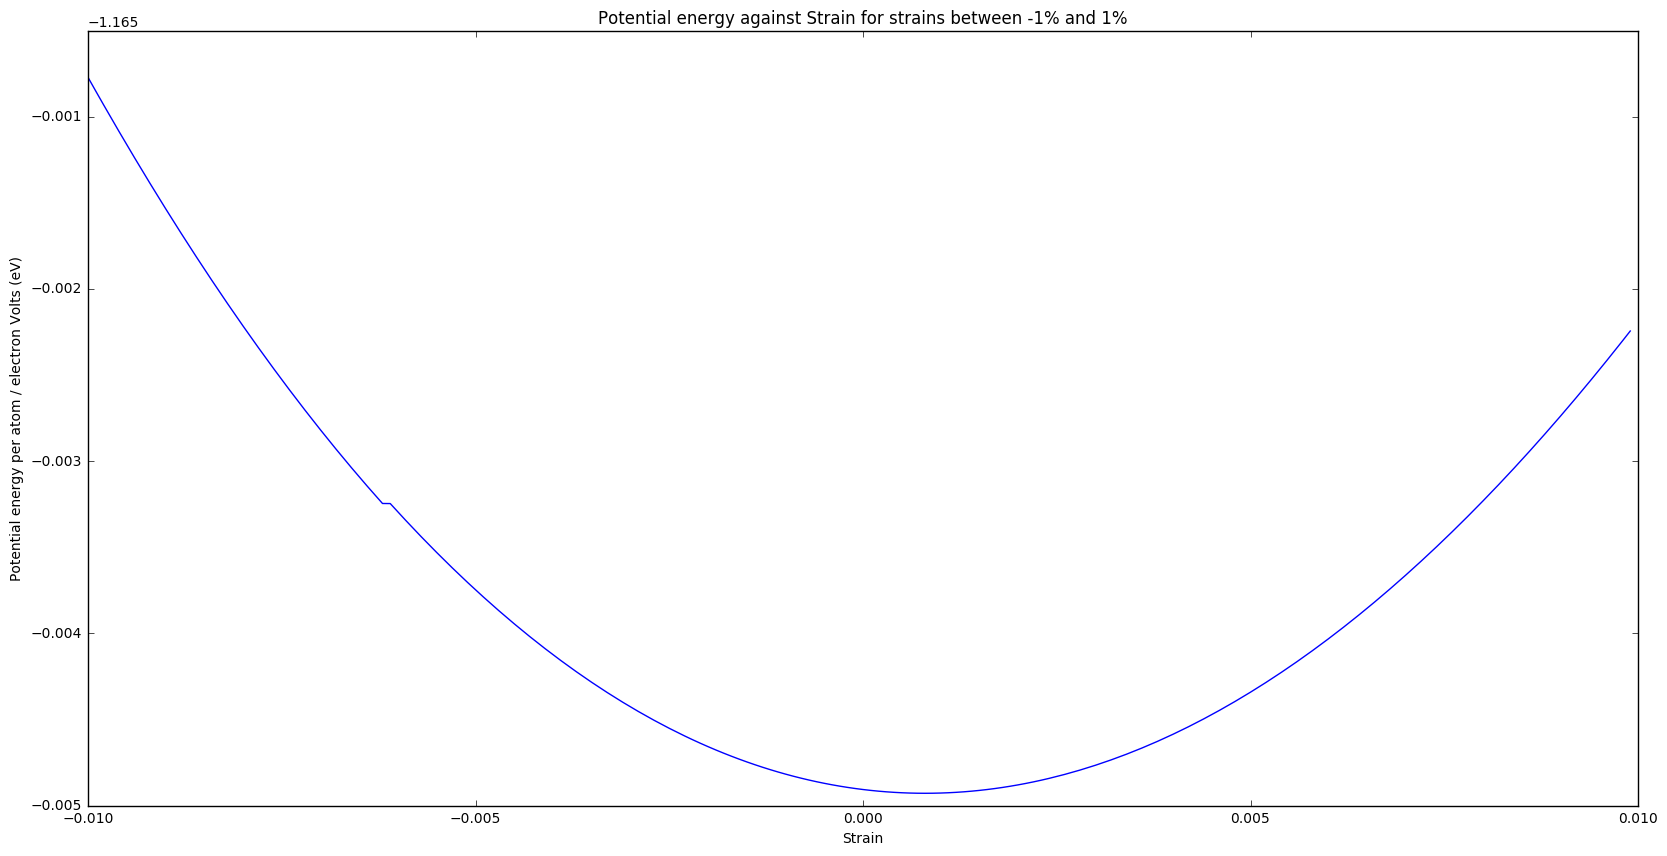

In [48]:
plt.figure(figsize = (20,10))
plt.plot(strains, PE_list)
plt.xlabel('Strain')
plt.ylabel('Potential energy per atom / electron Volts (eV)')
plt.title('Potential energy against Strain for strains between -1% and 1%')
plt.show()

The minimum energy is at 0.0008 strain

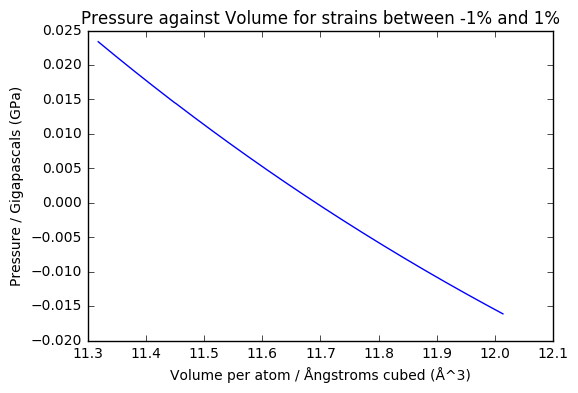

In [40]:
plt.plot(volume_list, pressure_list)
plt.xlabel('Volume per atom / Ångstroms cubed (Å^3)')
plt.ylabel('Pressure / Gigapascals (GPa)')
plt.title('Pressure against Volume for strains between -1% and 1%')
plt.show()

In [58]:
eqm=0.0008
V_eqm = strainer(eqm)[2] # Equilibrium volume is at 0.0008% strain
e = 0.00001
dP = strainer(eqm+e)[1] - strainer(eqm-e)[1]
dV = strainer(eqm+e)[2] - strainer(eqm-e)[2]
K = -V_eqm * (dP/dV)
K = K/GPa
print(K)

103.81924204


Bulk modulus:  103.791634457 GPa


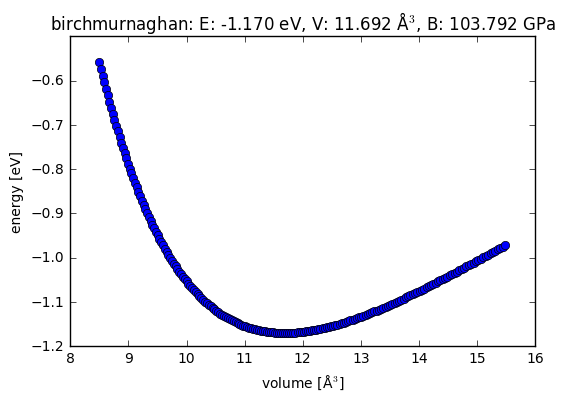

In [23]:
# Those who browse the documentation of ASE can discover that it has functionality to fit the equation of state
# and extract parameters using more accurate methods. Compare your result above to those computed by ASE. 

# The call below takes two arrays: the variable V is an array of volumes/atom and E
# is an array of corresponding potential energy values, again per atom. If you want to rexecute this
# notebook cell, you will need to substitute your own arrays for V and E.
from ase.eos import EquationOfState
from ase.units import kJ
eos = EquationOfState(volume_list, PE_list, eos="birchmurnaghan") # Birch-Murnaghan is a particular functional form fitted to the equation of state
v0, e0, B = eos.fit()
print('Bulk modulus: ', B / kJ * 1.0e24, 'GPa')
eos.plot()

### Task and Deliverable 1.4 

__Write a program to compute the [shear modulus](https://en.wikipedia.org/wiki/Shear_modulus).__

Hint: You can apply a shear in the XY plane by modifying the X component of the lattice vector that points originally in the Y direction, i.e. $L_{2x}$. Apply _small_ amounts of shear, i.e. a few percent. Starting with a cubic cell with side lengths L, new cell matrix, after applying 1% shear in the XY plane, would be given by

$$
\left[\begin{matrix}
L & 0.01L & 0\\0&L&0\\ 0&0&L
\end{matrix}\right]
$$

Just as before, in the hydrostatic case, after applying the shear strain in this way, you can get the corresponding (shear) stress simply by calling the ```get_stress()``` function. Observe which components of the stress matrix is nonzero, and think about which one you need to work out the shear modulus. 

The computed shear modulus of this model deviates from the experimental value by a bit more than the bulk modulus - this is typical for such simple models. 


In [24]:
strain = 0.01
cu = bulk("Cu", "fcc", a=3.6, cubic=True)
cu.set_calculator(calc)
cell = cu.get_cell()
cell[0][1] = (strain)*3.6 # Tensile strain is positive
cu.set_cell(cell, scale_atoms=True)
b = cu.get_stress(voigt=False)
G = (b[0][1])/strain
G = G/GPa
G

86.397845851270503

__Write a program to determine the [Poisson ratio](https://en.wikipedia.org/wiki/Poisson%27s_ratio)__

Hint: Recall that if the system is strained in the X direction by a normal strain (not shear), the resulting stress will not be purely in the X direction, but in addition to the stress in X there will be stress in the Y and Z directions also. If you now strain the system in an _equibiaxial_ way, so some amount of strain in X, and equal amounts in Y and Z, that is different from the strain in X, the Poisson ratio is the ratio of X and Y(and Z) strains that lead to no stress in the Y (and Z) directions. Think about the sign of the X strain and the Y(and Z) strains. Make sure you use a sensible range of strains. 

You should get a computed value that is within 20% of the experimentally observed one. 


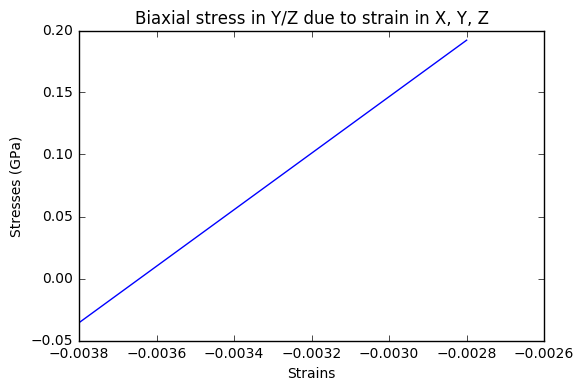

In [68]:
strains = np.arange(-0.0038, -0.002, 0.001)
stress = []
for strain in strains:
    cu = bulk("Cu", "fcc", a=3.6, cubic=True)
    cu.set_calculator(calc)
    cell = cu.get_cell()
    cell *= 1 + 0.0008
    cu.set_cell(cell, scale_atoms=True)
    cell[0][0] *= 1 + 0.01
    cell[1][1] *= 1 + strain
    cell[2][2] *= 1 + strain
    cu.set_cell(cell, scale_atoms=True)
    c = cu.get_stress(voigt=False)
    stress.append(c[1][1])
    
stress = np.array(stress)
stress = stress/GPa
plt.plot(strains, stress)
plt.xlabel('Strains')
plt.ylabel('Stresses (GPa)')
plt.title('Biaxial stress in Y/Z due to strain in X, Y, Z')
plt.show()

Zero stress in Y/Z occurs at a Y/Z strain of ~ -0.00365. Since +0.01 strain was applied in X, Poisson ratio ~0.365. Experimental Poisson ratio is 0.33.

### Milestone 2

For this milestone you will run a dynamical simulation that models a strain controlled tension experiment. 

![bar](./bar_annotated.png)

##### Task 2.1

You are supplied an [example program](run_cu_bar_2d_qs.py) which creates an atomistic model representing a notched bar. In order to speed up the computation, we employ periodic boundary conditions in one of the directions (Z) that is perpendicular to the direction that you will apply the strain along (X). 

In order to allow the simulation to run quickly, yet still see some pertinent effects, we focus on the area near the notch, that is where the plastic processes will originate. (In a macroscopic sample, there would be many defects within the material that serve as sources of plastic deformation, but here just the notch will do). In addition, the following approximations will also be made:

- Instead of following the evolution of the atomic positions in time, we will optimise the positions to find the lowest energy state corresponding to each particular applied strain. This can be accomplished much more quickly using sophisticated optimisation techniques (which you might learn more about in Part IIA), rather than by integrating forward the equations of motion for the atoms.
- You will observe only one kind of process, dislocation nucleation and glide. In a real material, or a more realistic model, there will be many different kinds of plastic processes. Some take more time than what you are able to simulate, some need preexisting flaws to start, some need multiple crystal grains and the grain boundaries between them, some need a more realistic length scale to be modelled. 

After you have run the program, in order to visualize the trajectory of atoms, download and install [Ovito](https://ovito.org), an atomistic visualisation tool. In Ovito you can open the trajectory file that is produced (ending with ```.xyz```), then you will need to check the "File contains multiple timesteps" checkbox on the right under the "XYZ File" heading, so that the animation controls to activate. The best way to see where deformation takes place is to colour the atoms according to their atomic energy, you can accomplish this by clicking on "Add Modification" in the top right panel, selecting "Color coding", and then selecting the "Potential energy" property from the dropdown menu, then click on "Adjust range".

_Note: the simulation with the default parameters can take several hours to run, depending on the speed of your computer, but you can visualise the trajectory while it is being generated. Clicking the "Reload animation frames" button under the "External data sources" tab loads the most recent version of the trajectory file into Ovito._

_The time taken to run the simulation is not counted within the "lab time", go and do something else while the simulations are running!_

### Deliverable 2.1

__Carry out a tension simulation, and identify the strain at which the first dislocation nucleates.__

* __Describe what happens to the dislocation subsequently: How do the dislocations and free surfaces interact? What happens to the dislocations that reach the fixed part of the bar that corresponds to the "grips" in your experiment?__ 
* __What happens to the notch?__
* __Use Ovito to produce ("render") a movie of the evolution of the bar.__


### Deliverable 2.2

__Change the simulation to alter the length of the initial notch, and run the simulation again. How does the critical strain change? __

__Modify the program to create an empty void in the middle of the bar (which is another typical flaw found in metals), instead of the two notches. Observe the evolution of the shape of the bar and the void during the tension experiment. What happens to the volume of the void?__